In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

/home/dotrungkien/anaconda2/envs/py36-conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/chars74K/characters'

In [4]:
!ls data/chars74K

characters	EnglishHnd.tgz	FullImagesAndAnnotations_Frontal.tgz
EnglishFnt.tgz	EnglishImg.tgz


In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255.)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 36))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 5795 images belonging to 36 classes.
Found 36576 images belonging to 36 classes.
Found 3358 images belonging to 36 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [7]:
print(train_features.shape, train_labels.shape)

(2000, 8192) (2000, 36)


In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(36, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 357us/step - loss: 3.3788 - acc: 0.1235 - val_loss: 3.5093 - val_acc: 0.0960
Epoch 2/30
2000/2000 [==============================] - 0s 183us/step - loss: 2.9443 - acc: 0.2525 - val_loss: 3.3504 - val_acc: 0.1410
Epoch 3/30
2000/2000 [==============================] - 0s 177us/step - loss: 2.6944 - acc: 0.3315 - val_loss: 3.2132 - val_acc: 0.1700
Epoch 4/30
2000/2000 [==============================] - 0s 165us/step - loss: 2.4879 - acc: 0.3795 - val_loss: 3.0827 - val_acc: 0.1950
Epoch 5/30
2000/2000 [==============================] - 0s 187us/step - loss: 2.3003 - acc: 0.4300 - val_loss: 2.9737 - val_acc: 0.2180
Epoch 6/30
2000/2000 [==============================] - 0s 171us/step - loss: 2.1624 - acc: 0.4690 - val_loss: 2.8641 - val_acc: 0.2490
Epoch 7/30
2000/2000 [==============================] - 0s 195us/step - loss: 2.0370 - acc: 0.5030 - val_loss: 2.7695 - val_acc: 0.2640


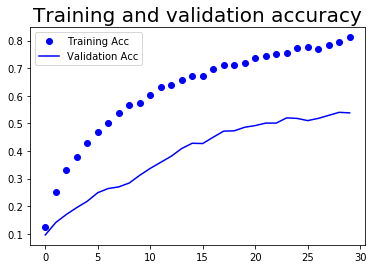

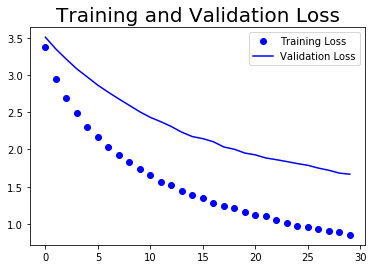

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.show()